# Project 3. Web API's and NLP, Reddit EDA

This project will collect text data from two parts of reddit.com and create a model to differentiate the two. The subreddit pages to be modeled are r/AskCulinary and r/cookingforbeginners. The data was collected over the holiday Thanksgiving, which is known as a very food centric event in the United States where the majority of reddit users live.

In [1]:
# Import several libraries to be used in EDA
import requests
import pandas as pd
import time

# Define the base URL for data collection
url = 'https://api.pushshift.io/reddit/search/submission'

## Data Collection

An initial scrape of both chosen subreddits is done here. A function is used later on to automate collection of more data from this initial collection. Reddit allows a maximum of 100 posts to be collected which necessitates this process. The final time in the data is 12/1 at midnight and data is collected backward from there to encompass the events around Thanksgiving.

In [2]:
# Parameters for r/AskCulinary
# Thanks to www.epochconverter.com for the epoch value
ac_params = {
    'subreddit' : 'AskCulinary',
    'size' : 100,
    'before' : 1606798800
}

In [3]:
# Parameters for r/cookingforbeginners
cfb_params = {
    'subreddit' : 'cookingforbeginners',
    'size' : 100,
    'before' : 1606798800
}

In [4]:
# Collects 100 posts from r/AskCulinary and converts them into a DataFrame
res = requests.get(url, ac_params)
ac = pd.DataFrame(res.json()['data'])
ac['title'].head()

0       Le Creuset enameled cast iron for bread baking
1    Does butter belong on the counter or in the fr...
2             These are not Croissants 🥐 lmfao help...
3                    Is salt considered an ingredient?
4               Best way to store hundreds of recipes?
Name: title, dtype: object

In [5]:
# Collects 100 posts from r/cookingforbeginners and converts them into a DataFrame
res = requests.get(url, cfb_params)
cfb = pd.DataFrame(res.json()['data'])
cfb['title'].head()

0    How do you make pan fried chicken crispy inste...
1                        Health Benefits of white rice
2    The only pot I have is a super old one that's ...
3                        Brown Sugar Glazed Spiral Ham
4                          Recipes for new appliances?
Name: title, dtype: object

This function is used to add more data to an existing scrape of reddit. It is run many times on the same data frame to collect the data needed for the classification model. The volume of posts on these subreddits is such that 3000 posts captures a large period before and after Thanksgiving.

In [6]:
# This function takes a dataframe of subreddit posts and adds 100 older posts.
def scrape_append(df, subred):
    url = 'https://api.pushshift.io/reddit/search/submission'
    ac_params = {
        'subreddit' : subred,
        'size' : 100,
        'before' : df['created_utc'].iloc[-1]
        }
    
    res = requests.get(url, ac_params)
    new_df = pd.DataFrame(res.json()['data'])
    
    # The function delays here to lessen the impact on reddit.com
    time.sleep(3)
    
    return pd.concat([df, new_df])

In [7]:
# Collect over 3000 posts for r/cookingforbeginners
for i in range(30):
    ac = scrape_append(ac,'AskCulinary')
ac.shape

(3100, 74)

In [8]:
# Collect over 3000 posts for r/cookingforbeginners
for i in range(30):
    cfb = scrape_append(cfb,'cookingforbeginners')
cfb.shape

(3100, 74)

## Data Cleaning

Begin by removing any duplicate posts in the collected data.

In [9]:
# Remove any duplicate rows that were collected
ac.drop_duplicates('title', inplace=True)
cfb.drop_duplicates('title', inplace=True)

In [10]:
# The collection has many more columns than I need. Here I remove most of them.
my_features = ['author','link_flair_text','num_comments','selftext','subreddit','title','created_utc']
ac = ac[my_features]
cfb = cfb[my_features]

Here I create a few extra columns to help explore the data. I create a column for the number of words in the title, another for the words in the selftext. I also create a column containing both the title and the selftext which will be the document for use in NLP.

In [11]:
# Create word count features
ac['title_word_count'] = [len(t.split(' ')) for t in ac['title']]
ac['text_word_count'] = [len(t.split(' ')) for t in ac['selftext'].astype(str)]

cfb['title_word_count'] = [len(t.split(' ')) for t in cfb['title']]
cfb['text_word_count'] = [len(t.split(' ')) for t in cfb['selftext'].astype(str)]

# Create the compound document
ac['words'] = [f"{ac['title'].iloc[i]} {ac['selftext'].iloc[i]}" 
                 for i in range(len(ac))]
cfb['words'] = [f"{cfb['title'].iloc[i]} {cfb['selftext'].iloc[i]}" 
                 for i in range(len(cfb))]

Here I create a DataFrame with all of my data. I continue using the subreddit DataFrames becuase I want to explore the data and create figures.

In [12]:
# Create a DataFrame with both of my subreddits. This is important for transforming my word vectors.
data = pd.concat([ac,cfb])

In [13]:
# Quick check on the shape to make sure everything worked properly
ac.shape

(3091, 10)

In [14]:
# Quick check on the shape to make sure everything worked properly
cfb.shape

(3061, 10)

In [15]:
# Quick check on the shape to make sure everything worked properly
data.shape

(6152, 10)

Here I have code to save and load the data. The collection process takes several minutes so it is convenient to save the data here so that I can restart the kernel without having to waste time or bandwidth.

In [16]:
# Write the collected data to a CSV file.
ac.to_csv('./data/ac.csv', index=False)
cfb.to_csv('./data/cfb.csv', index=False)
data.to_csv('./data/reddit_clean.csv', index=False)

In [17]:
# Load the CSV files, this is for convenience because the collection process takes several minutes
ac = pd.read_csv('./data/ac.csv')
cfb = pd.read_csv('./data/cfb.csv')
data = pd.read_csv('./data/reddit_clean.csv')

## Data Exploration

In this section I will explore the similarities and differences between the two subreddits. The subreddits were chosen because of a very similar subject so special attention is being paid to identify any key differences that the machine learning might be using to construct its model. 

In [18]:
# Import additional libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

Explore the activity of the two subreddits. Posts per day.

In [19]:
# Create a datetime feature so the plot will be more comprehensable.
import datetime

ac['dt'] = [datetime.datetime.fromtimestamp(ac['created_utc'].iloc[i]) for i in range(len(ac))]
cfb['dt'] = [datetime.datetime.fromtimestamp(cfb['created_utc'].iloc[i]) for i in range(len(cfb))]
data['dt'] = [datetime.datetime.fromtimestamp(data['created_utc'].iloc[i]) for i in range(len(data))]

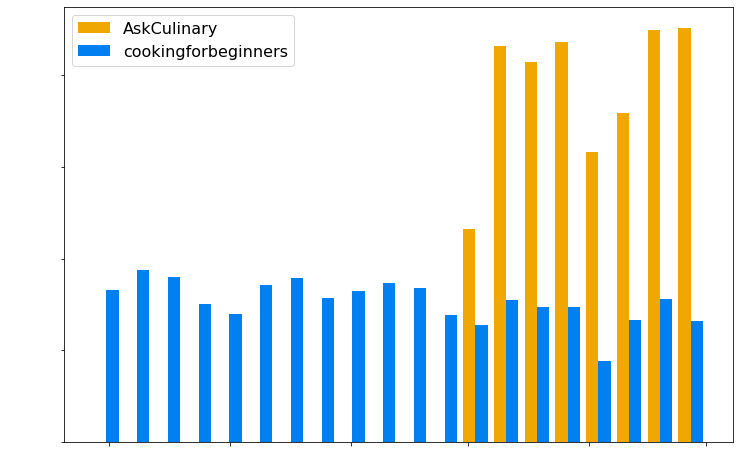

In [20]:
# Create a figure showing the activity of each subreddit.
plt.figure(figsize=(12,8))
plt.hist([ac['dt'], cfb['dt']], 
         color=['#f0a800','#0080f0'],
         bins=20,
         label=['AskCulinary','cookingforbeginners'])
plt.legend(fontsize=16)
plt.ylabel('Number of Posts', fontweight='bold', fontsize=16, color='white')
plt.xlabel('', fontsize=16, color='white')
plt.xticks(fontsize=16, color='white')
plt.yticks(fontsize=16, color='white')

plt.savefig("./images/Post_date.png")

This figure shows that the AskCulinary subreddit has much higher traffic than cookingforberginners. It also shows I collected much olders posts for cookingforbeginners. There is a conspicuous dip in early november, likely corrisponding to the US Presidential election.

Here I look for the overlap of users. There exist users who are in both communities and I want to see how much of an intersection there is.

In [21]:
# Collect and print many statistics about the data.
ac_mean = ac['author'].value_counts().mean()
print(f'The AskCulinary subreddit has a mean user post of {ac_mean}.')
print('12 posts have been deleted.')
print('kitchenrehab162563 has made 8 posts.')
print('2630 unique users.')
print('3093 posts were collected.')

print('')

cfb_mean = cfb['author'].value_counts().mean()

print(f'The cookingforbeginners subreddit has a mean user post of {cfb_mean}.')
print('37 posts have been deleted.')
print('hurrianawaz has made 53 posts.')
print('2263 unique users.')
print('3056 posts were collected.')

print('')

print('57 of 4837 users posted in both subreddits.')
print('southerngentleman90 (16, 1), gradstudent1234 (9, 2), bakedbeans18 (9, 2) had the largest combined posts.')

The AskCulinary subreddit has a mean user post of 1.1703900037864445.
12 posts have been deleted.
kitchenrehab162563 has made 8 posts.
2630 unique users.
3093 posts were collected.

The cookingforbeginners subreddit has a mean user post of 1.3460861917326297.
37 posts have been deleted.
hurrianawaz has made 53 posts.
2263 unique users.
3056 posts were collected.

57 of 4837 users posted in both subreddits.
southerngentleman90 (16, 1), gradstudent1234 (9, 2), bakedbeans18 (9, 2) had the largest combined posts.


In [22]:
# Print the top 5 highest posting authors for AskCulinary.
ac['author'].value_counts()[:5]

[deleted]             11
RationalIdiot          8
Rip-Electronic         7
kitchenrehab162563     7
Metalkon               7
Name: author, dtype: int64

In [23]:
# Count posts by users in both groups
shared_users = set(ac['author']).intersection(set(cfb['author']))
user_filter = [True if name in shared_users else False for name in data['author']]
data[user_filter]['author'].value_counts()[:5]

[deleted]          44
bakedbeans18       12
gradstudent1234    11
inthischef          9
Climaxical          8
Name: author, dtype: int64

In [24]:
# Look at a specific authors posts, this is one of the shared users.
data[data['author'] == 'Alex-BU']['title']

1085    Quick cooking product survey!
3446    Quick cooking product survey!
Name: title, dtype: object

Here I will explore the wordcounts of the two subreddits.

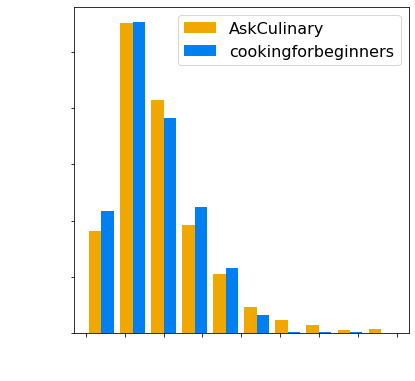

In [25]:
# Create a histagram of the number of words in the title
plt.figure(figsize=(6,6))
plt.hist([ac['title_word_count'], cfb['title_word_count']], 
         color=['#f0a800','#0080f0'],
         bins=10,
         range=(0,40),
         label=['AskCulinary','cookingforbeginners'])
plt.legend(fontsize=16)
plt.ylabel('Number of Posts', fontweight='bold', fontsize=16, color='white')
plt.xlabel('Number of Words Used', fontweight='bold', fontsize=16, color='white')
plt.xticks(fontsize=16, color='white')
plt.yticks(fontsize=16, color='white')

plt.savefig("./images/title_word_count.png")

This figure shows that the title length is very similar between both subreddits. The gap between 5-8 is perhaps caused by titles which are brief and titles which are complete sentences, regaurdless of cause the feature is present in both datasets.

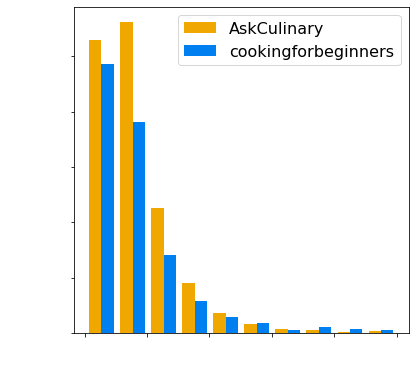

In [26]:
# Create a histagram of the number of words in the selftext
plt.figure(figsize=(6,6))
plt.hist([ac['text_word_count'], cfb['text_word_count']], 
         color=['#f0a800','#0080f0'],
         bins=10,
         range=(2,500),
         label=['AskCulinary','cookingforbeginners'])
plt.legend(fontsize=16)

plt.ylabel('Number of Posts', fontweight='bold', fontsize=16, color='white')
plt.xlabel('Number of Words Used', fontweight='bold', fontsize=16, color='white')
plt.xticks(fontsize=16, color='white')
plt.yticks(fontsize=16, color='white')

plt.savefig("./images/text_word_count.png")

This figure shows that the word counts for AskCulinary trend smaller than cookingforbeginners. The difference is slight but noticable.

### Create Word Vectors

I will look at the words used in the following section. I will transform the documents into word vectors. Here I create wordvectors with ngrams 1-3.

In [27]:
# This transforms the words into ngram = 1
cvec = CountVectorizer(stop_words='english', max_df=0.9, min_df=10, max_features=10000)
cvec.fit(data['words'])

mat = cvec.transform(ac['words'])
ac_word = pd.DataFrame(mat.todense(),columns=cvec.get_feature_names())

mat = cvec.transform(cfb['words'])
cfb_word = pd.DataFrame(mat.todense(),columns=cvec.get_feature_names())

In [28]:
# This transforms the words into ngram = 2
cvec2 = CountVectorizer(stop_words='english', max_df=0.9, min_df=10, ngram_range=(2,2))
cvec2.fit(data['words'])

mat = cvec2.transform(ac['words'])
ac_word2 = pd.DataFrame(mat.todense(),columns=cvec2.get_feature_names())

mat = cvec2.transform(cfb['words'])
cfb_word2 = pd.DataFrame(mat.todense(),columns=cvec2.get_feature_names())

In [29]:
# This transforms the words into ngram = 3
cvec3 = CountVectorizer(stop_words='english', max_df=0.9, min_df=10, ngram_range=(3,3))
cvec3.fit(data['words'])

mat = cvec3.transform(ac['words'])
ac_word3 = pd.DataFrame(mat.todense(),columns=cvec3.get_feature_names())

mat = cvec3.transform(cfb['words'])
cfb_word3 = pd.DataFrame(mat.todense(),columns=cvec3.get_feature_names())

Here I will plot the frequency of a selection of words. Word choice is mostly arbitrary, hopefully they are fun and interesting.

In [30]:
# Create a list of compelling words for the plot. If a word is absent from the dataset there will be an error.
plot_words = ['turkey','sauce','burnt','rice', 'thanksgiving','burn',
              'cook','chicken','gravy','taste']

In [31]:
word_plot_df = pd.DataFrame()
word_plot_df['ac'] = ac_word.sum().loc[plot_words].sort_values()
word_plot_df['cfb'] = cfb_word.sum().loc[plot_words]

<Figure size 864x576 with 0 Axes>

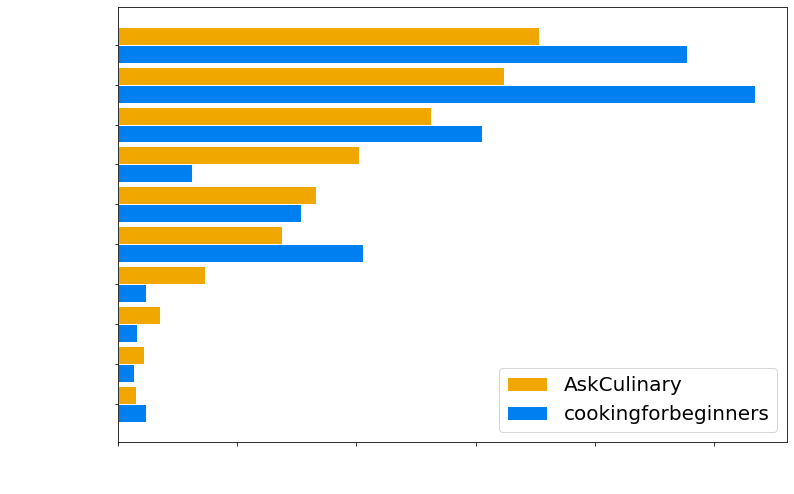

In [32]:
# Create a plot showing the frequency of words used by subreddit
# https://python-graph-gallery.com/11-grouped-barplot/
plt.figure(figsize=(12,8))

# set width of bar
barWidth = 0.45
 
# Set position of bar on X axis
rac = [x + barWidth*1.5 for x in range(len(word_plot_df))]
rcfb = [x + barWidth*0.5 for x in range(len(word_plot_df))]
 
# Make the plot
plt.figure(figsize=(12,8))
plt.barh(rac, word_plot_df['ac'], color='#f0a800', height=barWidth, edgecolor='white', label='AskCulinary')
plt.barh(rcfb, word_plot_df['cfb'], color='#0080f0', height=barWidth, edgecolor='white', label='cookingforbeginners')
 
# Add xticks on the middle of the group bars
plt.xlabel('Number of Times Used', fontweight='bold', fontsize=20, color='white')
plt.yticks([r + barWidth for r in range(len(word_plot_df))], word_plot_df.index, fontsize=16, color='white')
plt.xticks(fontsize=16, color='white')
 
# Create legend & Show graphic
plt.legend(fontsize=20)

plt.savefig("./images/word_count.png");

This figure shows that there are a few differences between word use in the subreddits. Most notably is in the words 'thanksgiving' 'turkey' and 'gravy', words associated with the holiday.

The remainder of this notebook is left for the reader to view the top words in each ngram range, just for fun. Your welcome!

In [33]:
# AskCulinary ngram = 1
ac_word.sum().sort_values(ascending=False).head(10)

like       1286
make       1286
just       1148
ve         1046
recipe      898
use         895
cooking     735
chicken     707
time        659
cook        647
dtype: int64

In [34]:
# cookingforbeginners ngram = 1
cfb_word.sum().sort_values(ascending=False).head(10)

make       1279
cook       1069
like       1038
just       1029
cooking    1006
chicken     954
recipe      937
add         787
use         705
ve          697
dtype: int64

In [35]:
# AskCulinary ngram = 2
ac_word2.sum().sort_values(ascending=False).head(10)

https www         261
imgur com         155
https imgur       143
cast iron         142
thanks advance    120
don know          112
amp x200b         105
want make          98
don want           88
ve seen            87
dtype: int64

In [36]:
# cookingforbeginners ngram = 2
cfb_word2.sum().sort_values(ascending=False).head(10)

https youtu       195
https www         149
don know          140
amp x200b         113
salt pepper       113
olive oil          97
soy sauce          79
chicken breast     79
imgur com          73
want make          73
dtype: int64

In [37]:
# AskCulinary ngram = 3
ac_word3.sum().sort_values(ascending=False).head(10)

https imgur com          143
www youtube com           42
https www youtube         42
recipe https www          37
youtube com watch         35
imgur com gallery         26
https www amazon          24
www seriouseats com       24
https www seriouseats     24
cast iron pan             21
dtype: int64

In [38]:
# cookingforbeginners ngram = 3
cfb_word3.sum().sort_values(ascending=False).head(10)

https imgur com                     69
www reddit com                      27
https www reddit                    27
imgur com gallery                   25
link https youtu                    24
don really know                     18
recipe https www                    18
reddit com cookingforbeginners      17
video link https                    17
com cookingforbeginners comments    17
dtype: int64